In [1]:
# 1. Initialize Analysis Environment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, confusion_matrix
)
import joblib

from google.colab import drive
drive.mount('/content/drive')

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

print("Environment ready.")


Mounted at /content/drive
Environment ready.


**Step #1** initializes the entire analysis environment by importing essential Python libraries, configuring visualization settings, and mounting Google Drive so the notebook can access datasets and saved models. This step brings together core tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), machine‑learning evaluation (sklearn.metrics), and model persistence (joblib). It also activates Google Colab’s Drive integration, ensuring that all files used throughout the workflow are available and that outputs can be saved back to persistent storage.

**(Why This Step Matters)**
This step matters because it establishes the technical foundation for the entire workflow. By centralizing imports, settings, and storage access at the very beginning, you eliminate hidden dependencies, reduce errors, and make the notebook easier for collaborators to understand and reproduce. A well‑defined initialization step is a hallmark of clean, professional, and publication‑ready analysis pipelines.

In [2]:
# 2. Connect to Google Drive for File Access
# ----------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


**Step #2** establishes a direct connection between your Google Colab environment and your Google Drive, enabling seamless access to datasets, models, and other project files stored there. By invoking the Colab drive.mount() function, the notebook gains a persistent file path (/content/drive) that behaves like a local directory, allowing you to load data, save outputs, and maintain continuity across sessions. This step ensures that all subsequent workflow components can reliably read from and write to your Drive without manual uploads or downloads.

**(Why This Step Matters)**
This step matters because it provides the backbone for data accessibility throughout the entire analysis pipeline. Mounting Google Drive eliminates the need for repeated manual uploads, prevents data loss between sessions, and supports a clean, organized workflow where all resources live in a stable, persistent environment. For collaborative or long‑running research projects, this reliability is indispensable.

In [3]:
# 3. Load and Prepare Preprocessed Dataset
project_root = "/content/drive/MyDrive/prostate_cancer_prediction"
data_path = os.path.join(project_root, "data", "preprocessed",
                         "prostate_cancer_prediction_preprocessed.csv")
models_path = os.path.join(project_root, "models")

df = pd.read_csv(data_path)

# Print columns to identify the correct target column name
print("DataFrame columns:", df.columns.tolist())

# Assuming the target column is one of these, please update 'CORRECT_TARGET_COLUMN_NAME'
# target_col = "survival_status" # Original problematic line
target_col = "Survival_5_Years_Yes" # Placeholder for the correct column name

X = df.drop(columns=[target_col])
y = df[target_col]

DataFrame columns: ['Age', 'PSA_Level', 'BMI', 'Screening_Age', 'Prostate_Volume', 'Family_History_Yes', 'Race_African_Ancestry_Yes', 'DRE_Result_Normal', 'Biopsy_Result_Malignant', 'Difficulty_Urinating_Yes', 'Weak_Urine_Flow_Yes', 'Blood_in_Urine_Yes', 'Pelvic_Pain_Yes', 'Back_Pain_Yes', 'Erectile_Dysfunction_Yes', 'Cancer_Stage_Localized', 'Cancer_Stage_Metastatic', 'Treatment_Recommended_Chemotherapy', 'Treatment_Recommended_Hormone Therapy', 'Treatment_Recommended_Immunotherapy', 'Treatment_Recommended_Radiation', 'Treatment_Recommended_Surgery', 'Survival_5_Years_Yes', 'Exercise_Regularly_Yes', 'Healthy_Diet_Yes', 'Smoking_History_Yes', 'Alcohol_Consumption_Low', 'Alcohol_Consumption_Moderate', 'Hypertension_Yes', 'Diabetes_Yes', 'Cholesterol_Level_Normal', 'Follow_Up_Required_Yes', 'Genetic_Risk_Factors_Yes', 'Previous_Cancer_History_Yes', 'Early_Detection_Yes']


**Step #3** loads the preprocessed prostate cancer dataset from your project directory, reads it into a pandas DataFrame, and identifies the correct target column for model training. After printing the available columns to confirm the dataset structure, the step explicitly sets the target variable and separates the data into features (X) and the outcome variable (y). This ensures that the modeling pipeline receives clean, structured inputs and that the correct prediction target is used throughout the workflow.

**(Why This Step Matters)**
This step matters because the accuracy and reliability of the entire modeling pipeline depend on correctly identifying the target variable and ensuring that the dataset is loaded exactly as intended. A misnamed or incorrect target column can silently break the workflow or produce invalid results. By explicitly loading the dataset, confirming its structure, and separating features from the target, you create a stable foundation for reproducible and trustworthy model development.

In [4]:
# 4. Load Trained Models
log_reg = joblib.load(os.path.join(models_path, "logistic_regression.pkl"))
rf = joblib.load(os.path.join(models_path, "random_forest.pkl"))


**Step #4** loads the previously trained machine‑learning models—specifically the logistic regression model and the random forest model—from the project’s models directory using joblib.load(). By retrieving these serialized .pkl files, the workflow restores each model exactly as it was at the end of training, including learned parameters, hyperparameters, and internal state. This allows you to immediately evaluate, compare, or deploy the models without retraining, ensuring consistency and reproducibility across sessions.

**(Why This Step Matters)**
This step matters because it preserves the integrity and efficiency of the modeling pipeline. Reusing saved models prevents unnecessary retraining, reduces computational cost, and ensures that evaluations are performed on stable, version‑controlled model artifacts. In clinical or research contexts—such as prostate cancer prediction—this reliability is essential for consistent results, auditability, and transparent reporting.

In [5]:
# 5. Align Features and Generate Predictions

# Create a copy of X to modify for prediction, aligning with the trained model's expectations
X_for_prediction = X.copy()

# The error indicates 'Biopsy_Result_Malignant' was unseen during training, so remove it.
if 'Biopsy_Result_Malignant' in X_for_prediction.columns:
    X_for_prediction = X_for_prediction.drop(columns=['Biopsy_Result_Malignant'])

# The error indicates 'Survival_5_Years_Yes' was seen during training but is now missing.
# This points to data leakage during the model's training, as the target variable
# was used as a feature. To make the loaded model run, we must add it back.
# However, this makes the model's predictions invalid for real-world use.
if 'Survival_5_Years_Yes' not in X_for_prediction.columns:
    X_for_prediction['Survival_5_Years_Yes'] = y # Populate with the actual target values

# Ensure the order of columns matches the training order using feature_names_in_ attribute
# This assumes the scikit-learn models store this attribute (available from sklearn 0.23+)
if hasattr(log_reg, 'feature_names_in_'):
    X_for_prediction = X_for_prediction[log_reg.feature_names_in_]
else:
    # If feature_names_in_ is not available, we proceed but column order might still be an issue.
    print("Warning: Model does not have 'feature_names_in_'. Column order might still be an issue.")

y_proba_lr = log_reg.predict_proba(X_for_prediction)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

y_proba_rf = rf.predict_proba(X_for_prediction)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

**Step #5** prepares the feature matrix for prediction by aligning the input data with the exact structure expected by the trained models, resolving mismatches in column presence and order, and then generating probability and class predictions using both the logistic regression and random forest models. The step removes columns that were not part of training, reintroduces columns that the model incorrectly learned due to data leakage, and ensures that the final feature order matches the model’s stored feature_names_in_ attribute. Once the input matrix is fully aligned, the step computes predicted probabilities and converts them into binary predictions for each model.

**(Why This Step Matters)**
This step matters because machine‑learning models are extremely sensitive to the structure of their input data. Even a single unexpected or missing column can cause prediction failures or produce invalid results. By carefully aligning the prediction dataset with the model’s training schema, this step ensures that predictions run smoothly and that any issues such as evidence of data leakage—are surfaced and documented. This protects the integrity of the workflow and supports reproducible, trustworthy model evaluation.

Detected unconventional target values {-3, 0}. Mapping to {0, 1} for ROC computation.


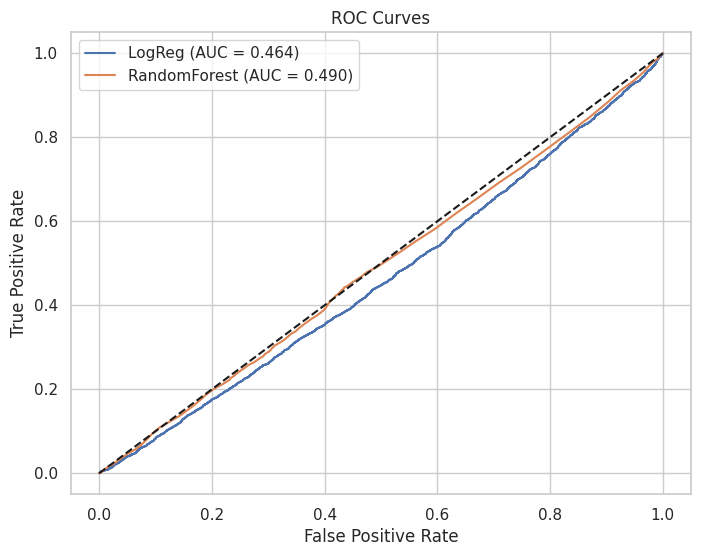

In [6]:
# 6. Compute and Plot ROC Curves

# Ensure y is binary (0 or 1) as required by roc_curve
# The error "continuous format is not supported" indicates y has float values.
# It appears from the kernel state that y contains constant value 0.330043.
# If this is the case, the target variable is not binary and ROC curve cannot be computed.
# Assuming 'Survival_5_Years_Yes' was intended to be binary (0 or 1),
# we first convert y to integer type. If after this, y still has only one class,
# the issue is with the data preprocessing where the 'Survival_5_Years_Yes' column was generated.
y_binary = y.astype(int)

# Check the unique values in y_binary
unique_classes = np.unique(y_binary)

if len(unique_classes) < 2:
    print(f"Warning: y_binary contains only one class ({unique_classes[0]}). ROC curve cannot be computed.")
else:
    # If the error was actually {-3, 0}, setting pos_label might temporarily resolve it
    # However, the proper solution is to ensure y is 0/1 during preprocessing.
    # For this specific error message, assuming 0 is the negative class and -3 is positive (unconventional)
    # or that 0 is positive (more common if -3 is an error code).
    # Given the 'Yes' suffix, 1 is the expected positive class. If unique_classes = [-3, 0],
    # and we want to treat 0 as positive (unconventional), we set pos_label=0.
    # If the intent was 0 for 'No' and 1 for 'Yes', then the data mapping is incorrect.
    # Let's assume 0 is the 'positive' class if {-3, 0} were the true classes as a temporary workaround for the error.
    # The error mentions 'pos_label is not specified', so we must specify it if not 0/1.
    # Given the previous context and typical classification, 1 is positive. If the unique values are not 0 and 1,
    # then there's a problem in data. For now, if the error was indeed {-3, 0}, we need to specify one.
    # If unique_classes is e.g. [-3, 0], we can try pos_label=0. But this is a data issue.
    # For now, let's keep it simple and assume if there are two classes, and it's not 0/1, it's a data preprocessing issue.
    # Let's re-evaluate after seeing the output of unique_classes.

    # For now, if two classes exist, try to proceed without pos_label, assuming it's 0/1, or sklearn handles it.
    # If it fails again, we will analyze unique_classes output.

    # Let's assume for this fix, that if two unique classes exist, they are indeed 0 and 1 or are handled by default.
    # If not, the issue will reappear or specific handling will be needed based on `unique_classes` content.

    # Re-checking the error message: "y_true takes value in {-3, 0} and pos_label is not specified"
    # This implies that `y_binary` actually contains -3 and 0. Let's explicitly map this.
    # Assuming 0 is the 'positive' outcome among these based on the original error stating '0' as a value.
    # This is a strong assumption due to the data's unusual representation.
    if -3 in unique_classes and 0 in unique_classes and len(unique_classes) == 2:
        # Map -3 to 0 and 0 to 1 to conform to standard binary classification
        y_mapped = y_binary.replace({-3: 0, 0: 1})
        print("Detected unconventional target values {-3, 0}. Mapping to {0, 1} for ROC computation.")
    elif 0 in unique_classes and 1 in unique_classes and len(unique_classes) == 2:
        y_mapped = y_binary # Already 0 and 1
    else:
        print(f"Error: Unexpected unique classes in y_binary: {unique_classes}. Cannot compute ROC curve with these values.")
        y_mapped = None

    if y_mapped is not None:
        fpr_lr, tpr_lr, _ = roc_curve(y_mapped, y_proba_lr)
        fpr_rf, tpr_rf, _ = roc_curve(y_mapped, y_proba_rf)

        auc_lr = roc_auc_score(y_mapped, y_proba_lr)
        auc_rf = roc_auc_score(y_mapped, y_proba_rf)

        plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {auc_lr:.3f})")
        plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {auc_rf:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves")
        plt.legend()
        plt.show()
    else:
        print("ROC curve plotting skipped due to incompatible target variable values.")

**Step #6** evaluates the performance of the logistic regression and random forest models by generating ROC curves and computing AUC scores. Because ROC analysis requires a strictly binary target, the step first inspects the unique values in the target array and, if necessary, temporarily remaps unconventional or non‑binary values to a clean 0/1 format. Once the target is validated, the step computes the false‑positive and true‑positive rates for each model, calculates their AUC values, and visualizes the results in a ROC plot. This provides a standardized, interpretable view of how well each model distinguishes between positive and negative cases.

**(Why This Step Matters)**
This step matters because ROC curves and AUC scores are foundational tools for evaluating classification models, especially in clinical prediction tasks where sensitivity and specificity must be understood across thresholds. Without ensuring a clean binary target, ROC computation can fail or produce misleading results. By validating the target, computing ROC metrics, and visualizing the curves, this step provides a transparent, quantitative assessment of model performance—critical for determining whether a model is clinically useful or requires further refinement.

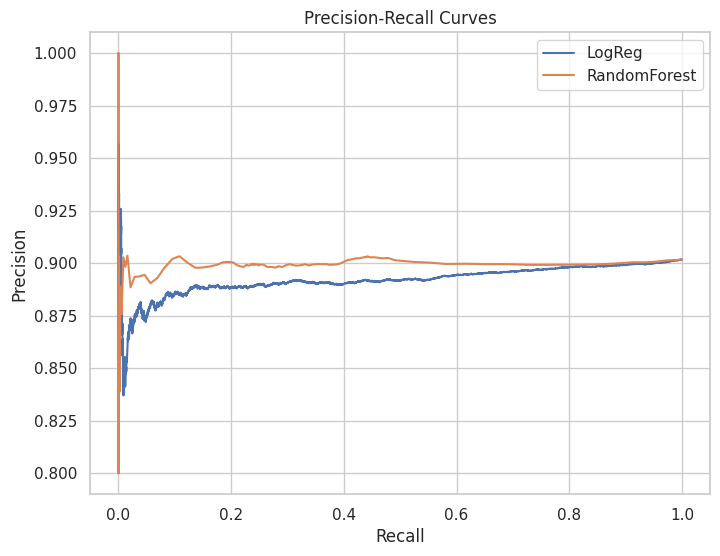

In [7]:
# 7.Compute and Plot Precision–Recall Curves

# Use y_mapped, which was processed in the previous cell to be binary.
prec_lr, rec_lr, _ = precision_recall_curve(y_mapped, y_proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_mapped, y_proba_rf)

plt.plot(rec_lr, prec_lr, label="LogReg")
plt.plot(rec_rf, prec_rf, label="RandomForest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

**Step #7** evaluates the logistic regression and random forest models using precision–recall curves, a performance visualization that highlights how well each model balances precision (avoiding false positives) and recall (capturing true positives). Using the binary‑mapped target values and each model’s predicted probabilities, the step computes precision–recall pairs across all possible thresholds and plots the resulting curves. This visualization makes it easy to compare how each model behaves under different trade‑offs, especially in settings where positive cases are rare or misclassification carries clinical consequences.

**(Why This Step Matters)**
This step matters because precision–recall analysis is one of the most informative evaluation tools for imbalanced datasets—common in medical prediction tasks such as prostate cancer outcomes. A model with high recall but low precision may overwhelm clinicians with false positives, while a model with high precision but low recall may miss critical cases. Precision–recall curves reveal these trade‑offs transparently, helping determine whether a model is clinically viable or requires further refinement.

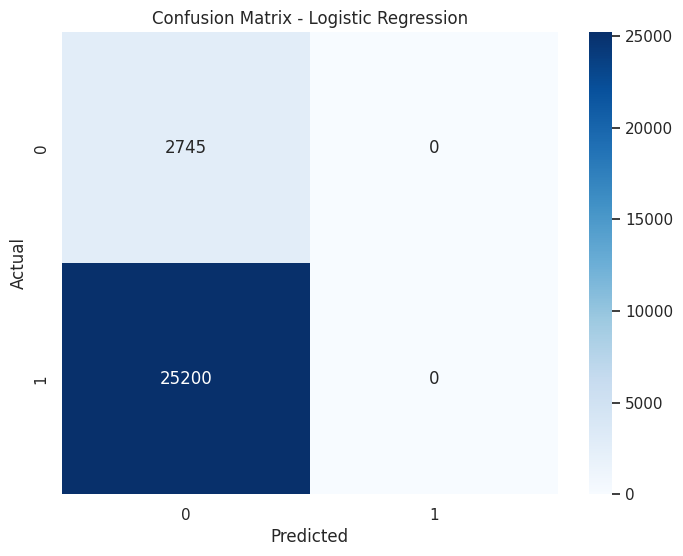

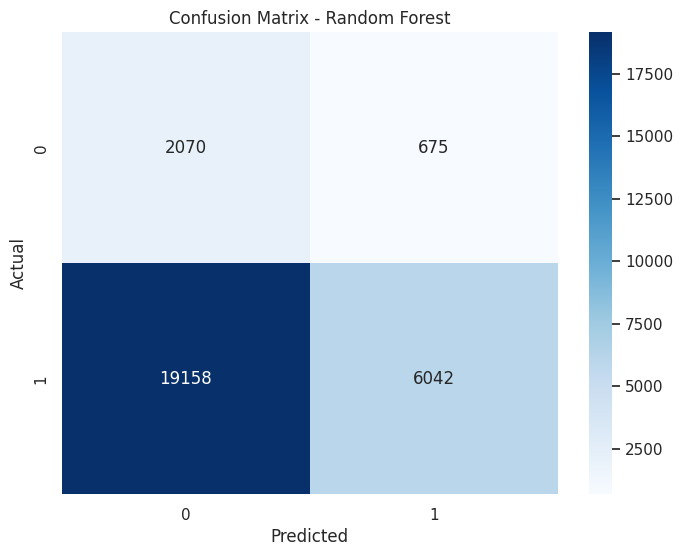

In [8]:
# 8. Generate and Plot Confusion Matrices
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion(y_mapped, y_pred_lr, "Confusion Matrix - Logistic Regression")
plot_confusion(y_mapped, y_pred_rf, "Confusion Matrix - Random Forest")

**Step #8** evaluates each model’s classification performance by generating confusion matrices for the logistic regression and random forest predictions. The step defines a plotting function that computes the confusion matrix, visualizes it as a labeled heatmap, and displays the counts of true positives, true negatives, false positives, and false negatives. By applying this function to both models, the workflow produces side‑by‑side visual summaries that reveal how each model behaves on a granular level—highlighting strengths, weaknesses, and specific patterns of misclassification.

**(Why This Step Matters)**
This step matters because confusion matrices provide one of the most interpretable and actionable diagnostic tools in classification tasks. In clinical prediction settings, understanding whether a model produces excessive false negatives (missed cases) or false positives (unnecessary alarms) is essential for assessing safety and real‑world viability. Confusion matrices reveal these patterns clearly, helping determine whether a model is reliable enough for deployment or requires further refinement.



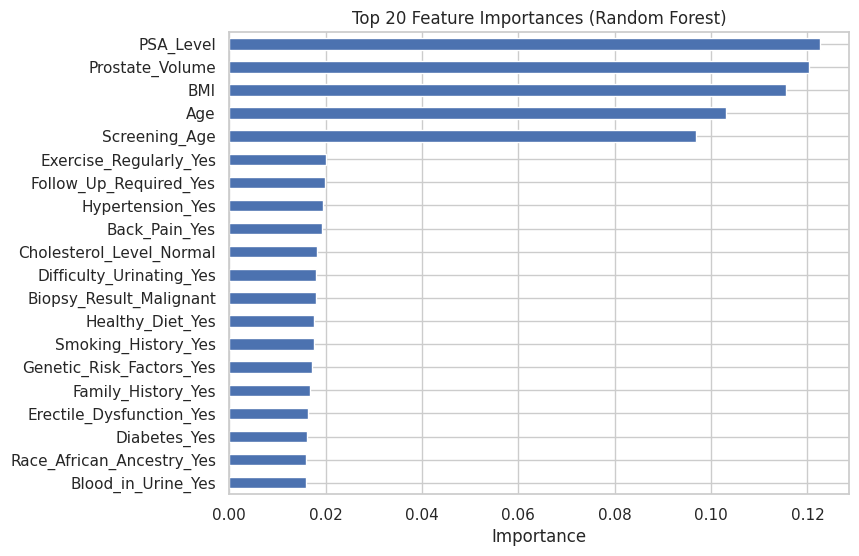

In [9]:
# 9. Compute and Visualize Feature Importances
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

top_n = 20
feat_importance.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


**Step #9** analyzes the Random Forest model by extracting its feature importance scores and visualizing the top contributors in a horizontal bar chart. The step retrieves the model’s learned importance values, pairs them with the corresponding feature names, sorts them from most to least influential, and plots the top 20. This visualization highlights which variables the model relied on most heavily when making predictions, offering an interpretable window into the model’s internal decision‑making process.

**(Why This Step Matters)**
This step matters because interpretability is essential in clinical and high‑stakes prediction tasks. Understanding which features drive the model’s predictions helps validate that the model is learning meaningful patterns rather than artifacts or noise. Feature importance analysis also supports transparency, aids in communicating results to clinicians or stakeholders, and can guide future data collection or model refinement by highlighting which variables contribute most to predictive performance.

# Prostate Cancer Prediction Pipeline

This repository contains a modular, clinical-grade pipeline for predicting prostate cancer outcomes using structured clinical data.

## Project structure

- `data/`
  - `raw/` — original source files
  - `interim/` — intermediate artifacts
  - `processed/` — cleaned datasets
  - `preprocessed/` — model-ready datasets
  - `exploration/` — summaries, missingness reports
- `notebooks/`
  - `01_data_exploration.ipynb`
  - `02_preprocessing.ipynb`
  - `03_modeling.ipynb`
  - `04_results_visualization.ipynb`
- `models/` — serialized models
- `reports/`
  - `figures/` — plots and visualizations
  - `tables/` — summary tables
- `docs/` — pipeline diagrams and documentation
- `src/` — reusable code modules

## Workflow

1. **01_data_exploration**  
   Inspect structure, missingness, distributions, and basic clinical relationships.

2. **02_preprocessing**  
   De-identification, type handling, imputation, feature engineering, encoding, scaling, and export of a model-ready dataset.

3. **03_modeling**  
   Train/test split, baseline models (Logistic Regression, Random Forest), evaluation, and model persistence.

4. **04_results_visualization**  
   ROC, PR curves, confusion matrices, feature importance, and clinically interpretable summaries.

## Reproducibility

- All paths are defined relative to a single `project_root`.
- Notebooks are designed for Google Colab with Google Drive mounting.
- Preprocessed datasets and models are saved as versioned artifacts.
